In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

sns.despine()
sns.set_context("poster")

<Figure size 432x288 with 0 Axes>

In [2]:
ct_names_dict = {"RoundSpermatid": "Round Spermatid",
 "Elongating": "Elongating Spermatid",
 "f-Pericyte": "Fibroblastic Pericyte",
 "m-Pericyte": "Muscular Pericyte",
 "Tcell" :"T-cell",
 "ImmLeydig": "Immature Leydig", 'other': 'Other',
 # these cell types remain the same
 'Macrophage': 'Macrophage', 'Endothelial':'Endothelial',
 'Myoid': 'Myoid', 'Spermatogonia': 'Spermatogonia',
 'Spermatocyte': 'Spermatocyte', 'Other': 'Other', }

order = ["Macrophage","Endothelial", "Immature Leydig", "T-cell", "Myoid",
         "Muscular Pericyte",
        "Spermatogonia",  "Spermatocyte", "Round Spermatid",
         "Elongating Spermatid"]



In [3]:
expression_folder = "/home/agalvezm/projects/cca/expression"

In [4]:
exp_fname = "transcript/oas1_4_isof_testis_other/metadata_expression.csv"

In [5]:
organ = 'testis'
home = '/home/cellatlas/human/data'
data = f'{home}/{organ}'

In [6]:
# Dictionary from transcript id to isoform common name

id_to_name = {'ENST00000445409.6': 'p48',
 'ENST00000452357.6': 'p42',
 'ENST00000202917.10': 'p46',
 'ENST00000551241.5': 'p44b',
}

### Read dataframe

In [7]:
# Read dataframe
df = pd.read_csv(f"{expression_folder}/{exp_fname}")

# Clean
df = df.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1', 'organ_x'])
df = df.rename(columns = {'organ_y': 'organ'})

# Annotate covid info
df["infected"] = ["infected" if "covid" in experiment else "healthy" for experiment in df.experiment]

# Replace transcript id by common name
df['target_id'] = [id_to_name[id] for id in df['target_id']]

# Create unique cell id
df['cell_id'] = [f"{obs_id}_{bc}" for obs_id, bc in zip(df['observation_id'], df['barcode'])]

# Beautify cell type names
df['cell_type'] = [ct_names_dict[ct] for ct in df['cell_type']]

df.head(n = 3)

,expression,target_id,barcode,observation_id,cell_type,DOI,organ,cell_origin,experiment,database_id,technology,infected,cell_id
0,0.0,p46,AAACCTGAGAATGTGT,GSM3526587,T-cell,Muus et al 2020,testis,ITGA6 enriched,Adult 1 ITGA6 enriched,GSE124263,10xv2,healthy,GSM3526587_AAACCTGAGAATGTGT
1,0.0,p46,AAACCTGAGAGAGCTC,GSM3526587,T-cell,Muus et al 2020,testis,ITGA6 enriched,Adult 1 ITGA6 enriched,GSE124263,10xv2,healthy,GSM3526587_AAACCTGAGAGAGCTC
2,0.0,p46,AAACCTGCAAGTTCTG,GSM3526587,T-cell,Muus et al 2020,testis,ITGA6 enriched,Adult 1 ITGA6 enriched,GSE124263,10xv2,healthy,GSM3526587_AAACCTGCAAGTTCTG


In [10]:
# Read mx assignments
observations = [d for d in os.listdir(data) if os.path.isdir(f'{data}/{d}')]

results = []
no_samples=0
for obs in tqdm(observations):
    try:

        mx_assignments = pd.read_csv(f'{data}/{obs}/mx_out/assignments_rank_mx.tsv', sep = '\t')
        mx_assignments = mx_assignments.rename(columns = {'Unnamed: 0': 'cell'})

        # Add observation column:
        mx_assignments['observation'] = obs         
        # Add to list
        results.append(mx_assignments)
        no_samples +=1
    except:
        continue
# Concatenate results
results_df = pd.concat(results)
print(no_samples)

100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


25


In [11]:
results_df['unique_id'] = [f'{o}_{b}' for b, o in zip(results_df['barcodes'], results_df['observation'])]

In [12]:
df_m = df.merge(results_df, left_on = 'cell_id', right_on = 'unique_id')

# Beautify celltype names
df_m['label'] = [ct_names_dict[ct] for ct in df_m['label']]



## OAS1 isoforms expression by cell type

In [13]:
# make healthy only df for healthy plots below
h_df = df.query("infected == 'healthy'")

### Relative isoform proportion

In [14]:
# Calculate sum expression of all isoforms
isoform_expression_sum = df_m.groupby('unique_id').sum()['expression'].to_frame()
isoform_expression_sum.columns = ['all_isoforms_expression']
isoform_expression_sum.head(n=3)

,all_isoforms_expression
unique_id,
GSM2928377_AAACCTGAGAGGTTAT,0.616966
GSM2928377_AAACCTGAGTTGAGTA,0.000000
GSM2928377_AAACCTGGTAAAGTCA,0.000000


In [15]:
# Merge with df
df_sum = df_m.merge(isoform_expression_sum, left_on = 'unique_id', right_on = 'unique_id')

In [16]:
# Calculate percentages
df_sum['isof_percentage'] = df_sum['expression'] / df_sum['all_isoforms_expression'] * 100
#df_sum['isof_percentage'] = df_sum['isof_percentage'].fillna(0)

In [17]:
# You can either fillNans or remove Nans

# FillNans
#df_sum['isof_percentage'] = df_sum['isof_percentage'].fillna(0)

# Remove Nans
df_sum = df_sum[~df_sum['isof_percentage'].isna()]

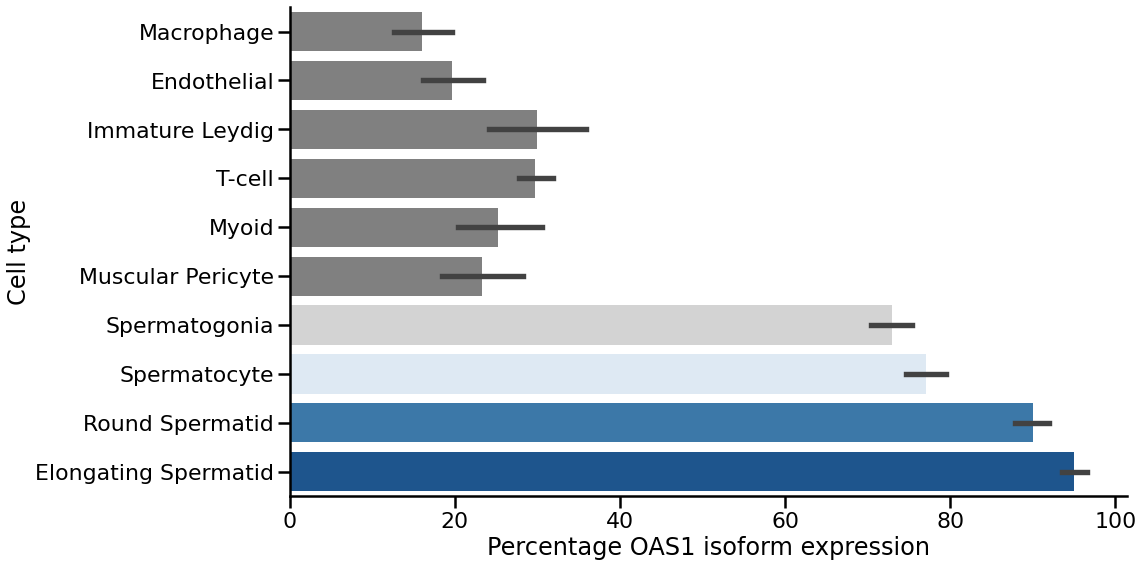

In [18]:
pal = sns.color_palette("Blues")

colors = ['gray', 'gray', 'gray', 'gray', 'gray','gray', 'lightgray', pal[0], pal[4],pal[5]]

plt.subplots(figsize=(15,9))
f = sns.barplot(data = df_sum.query('target_id == "p44b"'), x = 'isof_percentage', y = 'label', order = order, palette = colors)
f.set_xlabel("Percentage OAS1 isoform expression")
f.set_ylabel('Cell type')
sns.despine()
!mkdir -p figures
plt.savefig('figures/fig_2f.png')

#### Read gene expression and merge with isoforms

In [21]:
gene_exp_fname = "gene_name/oas1_testis/metadata_expression.csv"

In [22]:
# Read dataframe
gene_df = pd.read_csv(f"{expression_folder}/{gene_exp_fname}")

# Create unique cell id
gene_df['cell_id'] = [f"{obs_id}_{bc}" for obs_id, bc in zip(gene_df['observation_id'], gene_df['barcode'])]

# Rename column to make gene expression label unique
gene_df = gene_df.rename(columns = {'expression': 'gene_expression'})

# Subset to cell id and gene expression
gene_df = gene_df[['cell_id', 'gene_expression']]

In [23]:
# Merge with isoform df
gene_iso_df = df_sum.merge(gene_df, left_on = 'cell_id', right_on = 'cell_id')

## Analysis by observation id

In [24]:
rs_df = gene_iso_df.query('cell_type == "Round Spermatid"')


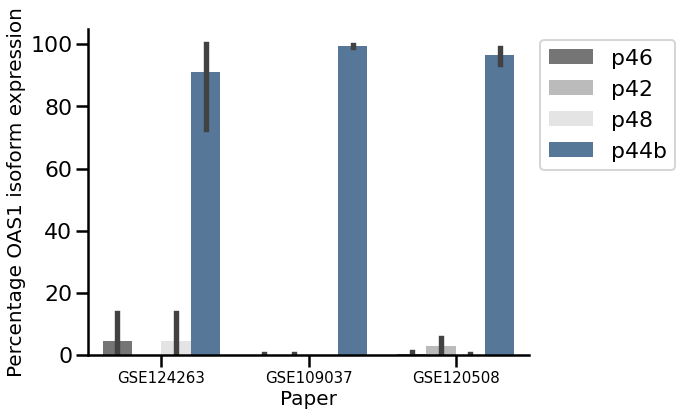

In [37]:
sns.set_context('poster')
fig, ax = plt.subplots(figsize=(10,6))
f = sns.barplot(data =rs_df, y = 'isof_percentage', x = 'database_id', hue = 'target_id',
                palette = ['#757575', '#BBBBBB', '#E4E4E4', '#4C77A4'], hue_order = ['p46', 'p42', 'p48', 'p44b'])
f.set_ylabel("Percentage OAS1 isoform expression", fontsize = 20)
f.set_xlabel('Paper', fontsize = 20)
plt.xticks(fontsize = 15)
ax.get_legend().remove()
sns.despine()
plt.tight_layout()
plt.legend(bbox_to_anchor = (1,1))
plt.tight_layout()
!mkdir -p figures
plt.savefig('figures/fig_s4.png')



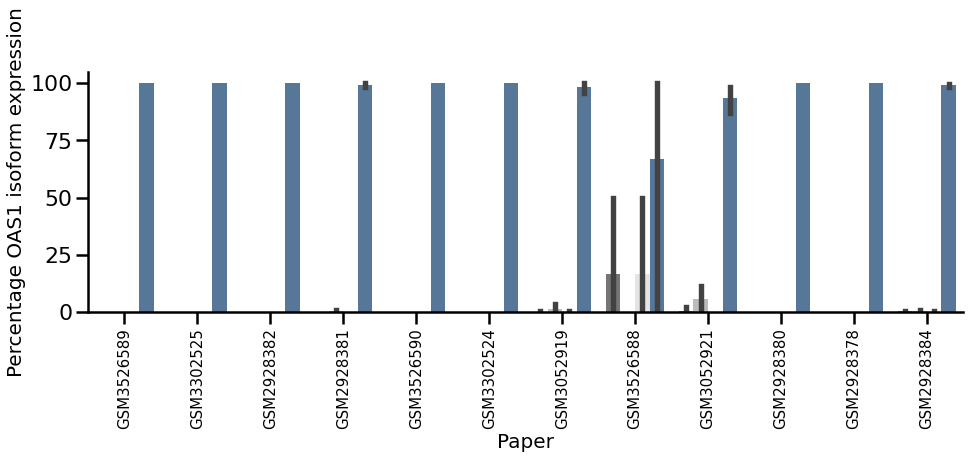

In [27]:
sns.set_context('poster')
fig, ax = plt.subplots(figsize=(14,6))
f = sns.barplot(data =rs_df, y = 'isof_percentage', x = 'observation_id', hue = 'target_id',
                palette = ['#757575', '#BBBBBB', '#E4E4E4', '#4C77A4'], hue_order = ['p46', 'p42', 'p48', 'p44b'])
f.set_ylabel("Percentage OAS1 isoform expression", fontsize = 20)
f.set_xlabel('Paper', fontsize = 20)
plt.xticks(fontsize = 15, rotation = 90)
ax.get_legend().remove()
sns.despine()
plt.tight_layout()
plt.savefig('p44b_roundspermatid_byobservation.pdf')